# Testing KERAS classification with MLP

In [1]:
from fastespy.mlkeras.evaluation import SplitData, plot_metric, plot_sig_vs_thr, get_sig_bkg_rate_eff, get_tp_fp_fn
from fastespy.mlkeras import models
from fastespy.ml import MLHyperParTuning
from fastespy.readpydata import convert_data_to_ML_format
from fastespy import feldman_cousins as fc
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import glob
import os
import tempfile
import logging
import numpy as np
import time
from pathlib import PosixPath
from fastespy.analysis import init_logging
sys.path.append("/Users/manuelmeyer/Python/fastespy/fastespy/scripts/")
sys.path.append("/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/scripts/")
from ml_intrinsic_bkg import load_data

2021-08-30 16:26:59.712780: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline

In [3]:
init_logging("INFO", color=True)

## Read data 

In [4]:
path = "/Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/" # May 2021 data
path = "/Users/manuelmeyer/Python/TESdata/data-01152021//" # August 2020 data
in_dir = PosixPath(path)
files = glob.glob(os.path.join(path, '*.npy'))

print(len(files))
#files

if not len(files):
    path = "/Users/manuelmeyer/Python/TESdata/data-05122021/"
    in_dir = PosixPath(path)
    files = glob.glob(os.path.join(path, '*.npy'))
    print(len(files))

17


In [5]:
files = list(in_dir.glob("*.npy"))

logging.info("Using files:")
for f in files:
    logging.info(f)

# define the feature names
feature_names = []
remove = ['data', 'time', 'pulse integral raw', 'voltage error',
          'error', 'start time in hrs', 'end time in hrs',
          'trigger time'
        ]

remove.append('constant')  # this seems to help

x = np.load(files[0], allow_pickle=True).tolist()
for k in x[1].keys():
    if not k in remove and not 'error' in k:
        feature_names.append(k)

logging.info("Using features names {}".format(feature_names))

 # define light cleaning cuts
light_cleaning_cuts = {
     "chi2 reduced": "chi2 < 6.",
    "decay time": "decay < 10.e-6",
    "trigger time": "(trigger >= 29.5e-6) & (trigger <= 30.8e-6)",  # from gaussian fit, 5 sigma interval
}

# read the data
result, data, t_tot_hrs = load_data(files, feature_names, light_cleaning_cuts=light_cleaning_cuts)

# convert data to ML format
X, y = convert_data_to_ML_format(result,
                                 feature_names,
                                 bkg_type=0,
                                 signal_type=1)

3247362142.py:   3 --- INFO: Using files:
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Python/TESdata/data-01152021/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-16-fit000.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Python/TESdata/data-01152021/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-3-fit000.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Python/TESdata/data-01152021/0.3RN-1.5GHz-light-000-fit.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Python/TESdata/data-01152021/0.3RN-1.5GBWP-intrinsics-50MHz-20mV-1day-9-fit000.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Python/TESdata/data-01152021/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-13-fit000.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Python/TESdata/data-01152021/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-14-fit000.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Python/TESdata/data-01152021/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-1-fit000.npy
3247362142.py:   5 --- INFO: /Users/manuelme

Do a log transform

In [6]:
X_log, y_log = MLHyperParTuning.transform_data_log(X.copy(), y.copy(), feature_names)

Discarded 234 triggers in log transform


/Users/manuelmeyer/Python/TESdata/fastespy/fastespy/ml.py:319: RuntimeWarning: divide by zero encountered in log10
  X[:, j] = np.log10(-X[:, j])


Get a split of the data (will be repeated later on):

In [7]:
sd = SplitData(X_log, y_log, n_splits=5, stratify=True, random_state=42)

In [8]:
i_split = 0
#X_train, X_test, y_train, y_test = sd.get_split(i_split)
X_train, X_val, y_train, y_val = sd.get_split_with_test_set(m=i_split, n=0)

Normalize the data

In [9]:
# normalize the input data
normalizer = Normalization(axis=-1)

# adapt to training data
normalizer.adapt(X_train)

# normalize training data
X_train = normalizer(X_train)
X_val = normalizer(X_val)
X_test = normalizer(sd.X_test)

### Define the model

In [10]:
initial_bias, initial_loss = models.initial_output_bias(y_train)
print(initial_bias, initial_loss)

[-3.60731045] [0.12202658]


In [11]:
n_nodes = 100
n_layers = 5
l2_regularizer = None
dropout = 0.1

In [169]:
import logging

class SignificanceMetric(keras.metrics.Metric):

  def __init__(self, name='significance',
               N_tot=1000.,
               e_d=0.5,
               n_s=2.8e-5,
               t_obs=20. * 24. * 3600.,
               thr=0.5,
               **kwargs):
    
    super(SignificanceMetric, self).__init__(name=name, **kwargs)

    self._N_tot = tf.cast(N_tot, self.dtype)
    self._e_d = tf.cast(e_d, self.dtype)
    self._n_s = tf.cast(n_s, self.dtype)
    self._t_obs = tf.cast(t_obs, self.dtype)
    self._thr = thr

    self.significance = self.add_weight(name='significance', initializer='zeros')
    self._n_samples = tf.Variable(0., name='current_sample_size', dtype=self.dtype)
    self._n_true_samples = tf.Variable(0., name='current_number_true_samples', dtype=self.dtype)
    self._tp_tot = tf.Variable(0., name='tp_total', dtype=self.dtype)
    self._fp_tot = tf.Variable(0., name='fp_total', dtype=self.dtype)
    
  def update_state(self, y_true, y_pred, sample_weight=None):
    
    y_pred = tf.greater_equal(y_pred, 0.5)
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
    
    batch_size = tf.cast(tf.shape(y_true)[0], self.dtype)
    self._n_samples.assign_add(batch_size)
    self._n_true_samples.assign_add(tf.reduce_sum(tf.cast(y_true, self.dtype)))
    
    # calculate efficiency, i.e., the number of true positives over all positives
    tp = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    tp = tf.reduce_sum(tf.cast(tp, self.dtype))
    self._tp_tot.assign_add(tp)
    efficiency = self._tp_tot / self._n_true_samples
    
    # false positive rate, i.e., false positives over sample size
    fp = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
    fp = tf.reduce_sum(tf.cast(fp, self.dtype))
    self._fp_tot.assign_add(fp)    
    fp_rate = self._fp_tot / self._n_samples

    # bkg rate: false positive rate times total number of triggers over obs time
    n_b = fp_rate * self._N_tot / self._t_obs
    
    # significance
    sig = 2. * (tf.sqrt(n_b + self._e_d * tp_rate * self._n_s) - tf.sqrt(n_b)) * tf.sqrt(self._t_obs)
    
    self.significance.assign(sig)

  def result(self):
    return self.significance

  def reset_states(self):
    # reset all values after each epoch
    self.significance.assign(0.)
    self._fp_tot.assign(0.)
    self._tp_tot.assign(0.)
    self._n_samples.assign(0.)
    self._n_true_samples.assign(0.)

In [172]:
sm = SignificanceMetric(N_tot=y_train.size + y_val.size + sd.y_test.size,
                        t_obs=t_tot_hrs * 3600.,
                        #dtype=tf.float
                       )

In [173]:
model = models.make_mlp_model(n_features=X_train.shape[1],
                              n_layers=n_layers,
                              n_nodes=n_nodes,
                              l2_regularizer=l2_regularizer,
                              dropout=dropout,
                              output_bias=initial_bias,
                              learning_rate=3e-4,
                              metrics=[sm,
                                       keras.metrics.FalsePositives(name='fp'), keras.metrics.TruePositives(name='tp'),
                                       keras.metrics.TrueNegatives(name='tn'),
                                       keras.metrics.FalseNegatives(name='fn')
                                      ]
                             )

In [174]:
EPOCHS = 200
BATCH_SIZE = 2048  # large enough so that you have enough signal samples in each batch

# early stopping if loss of validation set does not improve
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


Initial predictions

In [175]:
model.predict(X_train[10:]), y_train.sum() / y_train.size

(array([[0.02854541],
        [0.02767184],
        [0.02808678],
        ...,
        [0.03519779],
        [0.02707258],
        [0.0337961 ]], dtype=float32),
 0.026408382631558598)

In [176]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0, return_dict=True)

In [177]:
print(results)

{'loss': 0.12005095183849335, 'significance_metric': 0.0, 'significance': 0.0, 'fp': 0.0, 'tp': 0.0, 'tn': 25180.0, 'fn': 683.0}


In [178]:
results['loss'], initial_loss

(0.12005095183849335, array([0.12202658]))

Save the inital weights

In [179]:
initial_weights = os.path.join(tempfile.mkdtemp(), f'initial_weights_{n_layers}_{n_nodes}')
model.save_weights(initial_weights)

### Train the full model

In [180]:
model.summary()
model.load_weights(initial_weights)

Model: "mlp_binary"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 100)               700       
_________________________________________________________________
dropout_40 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense2 (Dense)               (None, 100)               10100     
_________________________________________________________________
dropout_41 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense3 (Dense)               (None, 100)               10100     
_________________________________________________________________
dropout_42 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense4 (Dense)               (None, 100)               1

In [181]:
t0 = time.time()
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val), 
    verbose=0,
    class_weight=None
)
t1 = time.time()
print("training took {0:.2f}s".format(t1-t0))

training took 31.32s


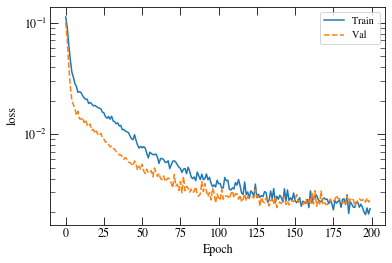

In [182]:
plot_metric(baseline_history)
plt.legend()

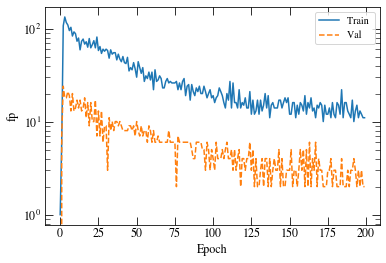

In [183]:
plot_metric(baseline_history, metric='fp')
plt.legend()

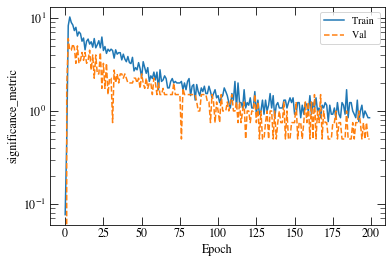

In [184]:
plot_metric(baseline_history, metric='significance_metric')
plt.legend()

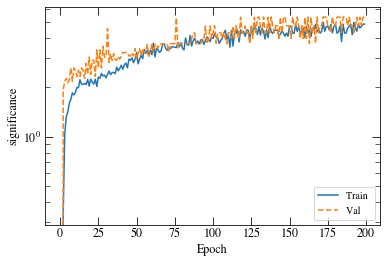

In [185]:
plot_metric(baseline_history, metric='significance')
plt.legend()

In [187]:
print(sm._n_samples)
print(sm._fp_tot)
print(sm._tp_tot)

<tf.Variable 'current_sample_size:0' shape=() dtype=float32, numpy=6466.0>
<tf.Variable 'fp_total:0' shape=() dtype=float32, numpy=2.0>
<tf.Variable 'tp_total:0' shape=() dtype=float32, numpy=170.0>


In [188]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0, return_dict=True)
print(results)

{'loss': 0.0013233291683718562, 'significance_metric': 0.692307710647583, 'significance': 5.169094562530518, 'fp': 9.0, 'tp': 682.0, 'tn': 25171.0, 'fn': 1.0}


In [190]:
print(sm._n_samples)
print(sm._fp_tot)
print(sm._tp_tot)

<tf.Variable 'current_sample_size:0' shape=() dtype=float32, numpy=25863.0>
<tf.Variable 'fp_total:0' shape=() dtype=float32, numpy=9.0>
<tf.Variable 'tp_total:0' shape=() dtype=float32, numpy=682.0>


### Evaluate metrics on training and validation set

In [191]:
thr = 0.5
y_pred = model.predict(X_train)

sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_train,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
print(sig, bkg_rate, eff)

5.1690949238048205 7.542589782120342e-06 0.9985358711566618


In [130]:
thr = 0.5
y_pred = model.predict(X_val)
#class_pred_test, tp, fp, fn = get_tp_fp_fn(y_val, y_pred, thr=thr)


sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_val,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
print(sig, bkg_rate, eff)

2.712952889935887 4.022559017114721e-05 0.9705882352941176


### Retrain with class weights

In [38]:
# weighting following
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

# original: increasing weight for class 1:
# false negatives go down, false positives go up
# significance goes down
weight_for_0 = 1 / (y.size - y.sum()) * (y.size / 2.)
weight_for_1 = 1 / y.sum() * (y.size / 2.)

# inverting weights: fp down, fn up, significance up!
power = 1.
weight_for_0 = 1. / (1 / (y.size - y.sum()) * (y.size / 2.))**power
weight_for_1 = 1. / (1 / y.sum() * (y.size / 2.))**power

print('Weight for class 0: {:.3f}'.format(weight_for_0))
print('Weight for class 1: {:.3f}'.format(weight_for_1))



Weight for class 0: 1.948
Weight for class 1: 0.052


In [39]:
use_class_weights = True

if use_class_weights:
    model.load_weights(initial_weights)
    print({0: weight_for_0, 1: weight_for_1})

    class_weight_history = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val), 
        verbose=0,
        class_weight={0: weight_for_0, 1: weight_for_1}
    )

{0: 1.9475471141071694, 1: 0.05245288589283078}


In [40]:
result = model.evaluate(X_val, return_dict=True)
print(result)

203/203 [==============================] - 0s 914us/step - loss: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00
{'loss': 0.0, 'tp': 0.0, 'fp': 0.0, 'tn': 0.0, 'fn': 0.0, 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'auc': 0.0, 'prc': 0.0}


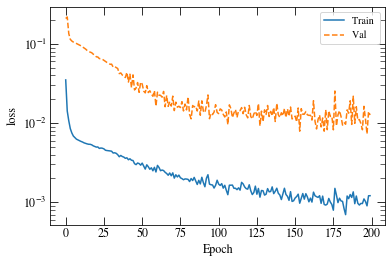

In [41]:
plot_metric(class_weight_history)
plt.legend()

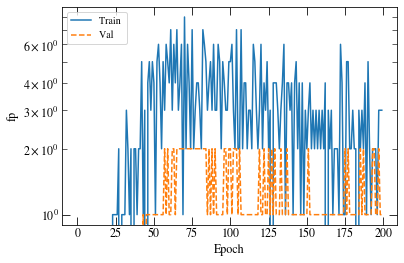

In [42]:
plot_metric(class_weight_history, metric='fp')
plt.legend()

In [43]:
thr = 0.5
y_pred = model.predict(X_train)

sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_train,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
print(sig, bkg_rate, eff)

9.169417326375909 0.0 0.8052708638360175


In [44]:
thr = 0.5
y_pred = model.predict(X_val)

sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_val,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
print(sig, bkg_rate, eff)

5.447123841771256 3.352132514262268e-06 0.8058823529411765


results as function of power in weight definition for May 2021 data

| power | weight 0 | weight 1 | sig val | bkg rate (Hz) val | eff val | 
|---|---|---|---|---|---|
| 0 | 1 | 1 | 1.95 | 8.20e-5 | 0.99 | 
| 1 | 1.53 | 0.47 | 2.26 | 5.7e-5 | 0.97 | 
| 2 | 2.33 | 0.22 | 2.34 | 4.99e-5 | 0.95 | 
| 3 | 3.558 | 0.106 | 2.91 | 2.49e-5 | 0.86 |
| 4 | 5.43 | 0.05 | 3.73 | 1.07e-5 | 0.80 | 
| 5 | 8.29 | 0.02 | 0. | 0. | 0. | 

As can be seen, class weights have similar effet as setting the threshold to a higher value than 0.5. FP goes down, TP also down. 

For August 2020 data:

| power | weight 0 | weight 1 | sig val | bkg rate (Hz) val | eff val | 
|---|---|---|---|---|---|
| 0 | 1 | 1 | 3.97 | 1.68e-05 | 1.0 | 
| 1 | 1.95 | 0.05 | 4.27 | 6.7e-6 | 0.75 | 
| 1.2 | 2.225 | 0.03 | 5.18 | 3.35e-6 | 0.75 | 
| 1.5 | 2.72 | 0.01 | 0 | 0| 0. | 
| 2 | 3.97 | 0.003 | 0. | 0. | 0. | 


## Significance as function of threshold

For validation set

Max significance: 5.74 for threshold 0.3386 background rate 3.35e-06 and analysis efficiency 0.86


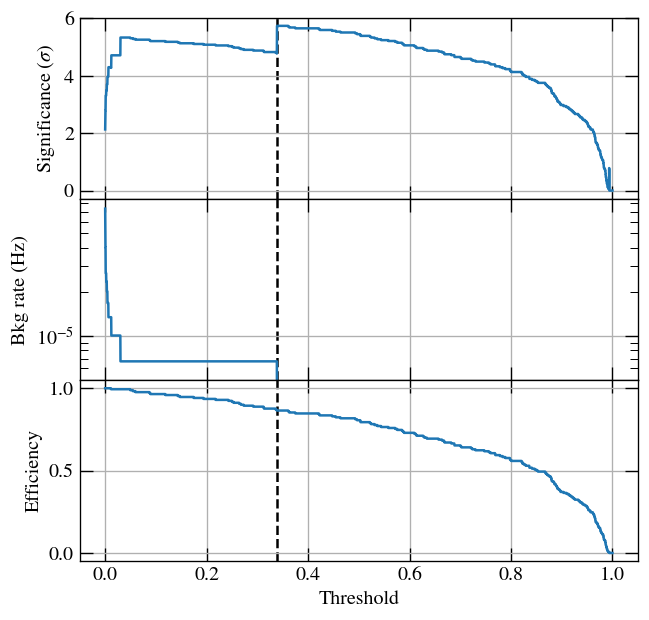

In [45]:
fig=plt.figure(dpi=120, figsize=(6,2*3))
ax, threshold, significance, bkg_rate, eff = plot_sig_vs_thr(model,
                                                             X_val,
                                                             y_val,
                                                             t_obs_hours=t_tot_hrs,
                                                             N_tot=y_train.size + y_val.size + sd.y_test.size)
plt.subplots_adjust(hspace=0.)

For training set

Max significance: 9.74 for threshold 0.2631 background rate 0.00e+00 and analysis efficiency 0.91


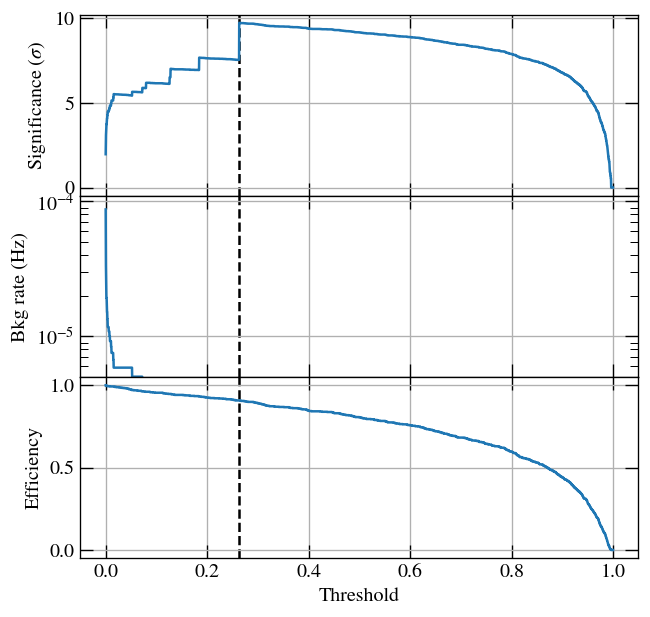

In [46]:
fig=plt.figure(dpi=120, figsize=(6,2*3))
ax, threshold, significance, bkg_rate, eff = plot_sig_vs_thr(model,
                                                             X_train,
                                                             y_train,
                                                             t_obs_hours=t_tot_hrs,
                                                             N_tot=y_train.size + y_val.size + sd.y_test.size)
plt.subplots_adjust(hspace=0.)
plt.savefig("KERAS_thr_dep.png")

Significance for test set with the threshold obtained from training set:

In [47]:
imax = np.argmax(significance)

In [48]:
y_pred = model.predict(normalizer(sd.X_test))

In [52]:
thr = threshold[imax]
#thr = 0.5
class_pred_test, tp, fp, fn = get_tp_fp_fn(sd.y_test, y_pred, thr=thr)

sig, bkg_rate, eff = get_sig_bkg_rate_eff(sd.y_test,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )

In [53]:
print(sig, bkg_rate, eff)

6.1414121344908175 2.6815401258468176e-06 0.8873239436619719


Plot false positives for test set

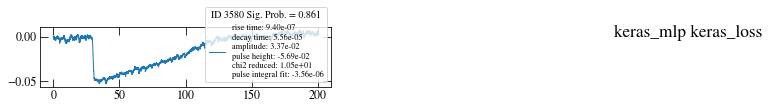

In [54]:
d = {}
d['y_test'] = sd.y_test
scorer = 'keras_loss'
d['y_pred_test'] = {scorer: class_pred_test}
d['idx_test'] = sd.idx_test
d['prob_test'] = {scorer: np.hstack([1. - y_pred, y_pred])}
d['classifier'] = "keras_mlp"

if fp.sum() < 50:
    ax = MLHyperParTuning.plot_misidentified_time_lines(
        d, scorer,
        data['time'],
        data['data'],
        X=X,  # give original data, for right values in legend
        feature_names=feature_names,
        plot_false_positive=True, save_plot=False
    )
plt.savefig("KERAS_miss_ids.png")

### Learning curve

### Repeat analysis over different folds

In [ ]:
n_nodes = 100
n_layers = 5
l2_regularizer = None
dropout = 0.1

0
Max significance: 3.31 for threshold 0.9926 background rate 1.25e-05 and analysis efficiency 0.74
1
Max significance: 3.44 for threshold 0.9934 background rate 8.02e-06 and analysis efficiency 0.65
2
Max significance: 4.20 for threshold 0.9952 background rate 2.67e-06 and analysis efficiency 0.55
3
Max significance: 4.51 for threshold 0.9920 background rate 4.45e-06 and analysis efficiency 0.72
4
Max significance: 4.32 for threshold 0.9958 background rate 3.56e-06 and analysis efficiency 0.63


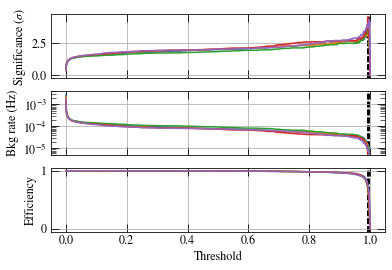

In [40]:
sig, br, ef = np.zeros(5), np.zeros(5), np.zeros(5)

for i in range(5):
    print(i)
    X_train, X_val, y_train, y_val = sd.get_split_with_test_set(m=i, n=0)
    
    # normalize the input data
    normalizer = Normalization(axis=-1)

    # adapt to training data
    normalizer.adapt(X_train)

    # normalize training data
    X_train = normalizer(X_train)
    X_val = normalizer(X_val)
    
    # calculate initial bias
    initial_bias, initial_loss = models.initial_output_bias(y_train)
    
    # the model
    model = models.make_mlp_model(n_features=X_train.shape[1],
                              n_layers=n_layers,
                              n_nodes=n_nodes,
                              l2_regularizer=l2_regularizer,
                              dropout=dropout,
                              output_bias=initial_bias,
                              learning_rate=3e-4
                             )
    
    # fit the model
    history = model.fit(X_train,
                        y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(X_val, y_val), 
                        verbose=0,
                        class_weight=class_weight
                        )
    
    # compute best threshold 
    ax, threshold, significance, bkg_rate, eff = plot_sig_vs_thr(model,
                                                                 X_train,
                                                                 y_train,
                                                                 t_obs_hours=t_tot_hrs,
                                                                 N_tot=y_train.size + y_test.size + sd.y_test.size)
    
    imax = np.argmax(significance)
    y_pred = model.predict(normalizer(sd.X_test))
    class_pred_test, tp, fp, fn = get_tp_fp_fn(sd.y_test, y_pred, thr=threshold[imax])

    sig[i], br[i], ef[i] = get_sig_bkg_rate_eff(sd.y_test,
                                                y_pred,
                                                N_tot=y_train.size + y_test.size + sd.y_test.size,
                                                t_obs=t_tot_hrs * 3600.,
                                               # thr=threshold[imax]
                                                 thr=0.5
                                               )
    
    del model

In [41]:
mean = np.vstack([sig, br, ef]).mean(axis=1)
std = np.sqrt(np.vstack([sig, br, ef]).var(axis=1))

print(mean)
print(std)

[2.22589459e+00 6.15704150e-05 9.91212282e-01]
[6.35817220e-02 3.86658214e-06 1.44395783e-03]
